# Import what we need

In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import math
import gc
import random

The current input file is /ye/yelabstore3/Richard/PlottingScripts/ez_scanpy/CLUESImmVar_processed.h5ad with a time stamp of 01/03/2019

In [2]:
##################
# Configure file #
##################
sc.settings.verbosity = 2
sc.settings.autoshow = False
logging.basicConfig(level=logging.INFO)
sc.settings.set_figure_params(dpi_save=600, format='png')
##plt.rcParams["markeredgecolor"] = "none"
plt.rcParams["image.aspect"] = "equal"

plt.switch_backend('agg')

dirpath = os.getcwd()
name = "CLUESImmVar_processed.V3.1"
##processed_path = "/Users/yechun/Downloads/"+name+".h5ad"
processed_path = os.readlink(name+'.h5ad');
# processed_path = os.path.normpath(processed_path)
print(processed_path)

../../../../../../../Downloads/CLUESImmVar_processed.V3.1.h5ad


# Read in the data, this could take a while

In [3]:
# Convenience method for computing the size of objects
def print_size_in_MB(x):
    print('{:.3} MB'.format(x.__sizeof__()/1e6))

In [4]:
## this will run it on the data with platelets
adata = sc.read(processed_path, cache=False)
print_size_in_MB(adata)

4.48e+03 MB


In [5]:
adata._X = adata._X.astype(np.float16, copy=False)
adata._X.nbytes
adata.shape
print_size_in_MB(adata)
gc.collect()

2.3e+03 MB


11

In [6]:
adata.shape

(786195, 1381)

In [7]:
## filter for 901015200_901015200 which has 11 cells
## also filter for IGTB1906 YE_8-30 which has very few cells as well

adata = adata[adata.obs.ind_cov != "901015200_901015200"]
adata = adata[~((adata.obs.ind_cov == "IGTB1906") & (adata.obs.batch_cov == "YE_0831"))]
adata.shape

(786195, 1381)

In [8]:
## remove samples that were processed twice and get rid of their 1.10 run
remove = ['902289200_902289200', '1262_1262', '1270_1270', '1279_1279']
adata = adata.copy()
adata = adata[~((adata.obs.ind_cov.isin(remove)) & (adata.obs.batch_cov == "lupus1.10"))]
adata.shape

(769639, 1381)

In [9]:
## remove samples that were processed twice and get rid of their 8.9 run
## since the 8.9 run has the fewest number of cells, this adjustment is important for testing for cell proportion differences
## going forward, we will want to combine batches for the same individuals
remove2 = ['1472_1472', '1479_1479', '1480_1480', '1492_1492', '1522_1522', '1535_1535', '1602_1602', '1615_1615', '1621_1621', '1716_1716', '1726_1726', '1730_1730']
adata = adata.copy()
adata = adata[~((adata.obs.ind_cov.isin(remove2)) & (adata.obs.batch_cov == "lupus8.9"))]
adata.shape

(744163, 1381)

# Make some diagnostic plots

In [10]:
%matplotlib inline

In [11]:
# sc.tl.rank_genes_groups(adata, n_genes=20, groupby='louvain', use_raw=False)
# #get violin plot with top marker per cluster
# sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=1,groupby='louvain', figsize=(15,5),palette=sc.pl.palettes.vega_20_scanpy)
# sc.pl.rank_genes_groups(adata)

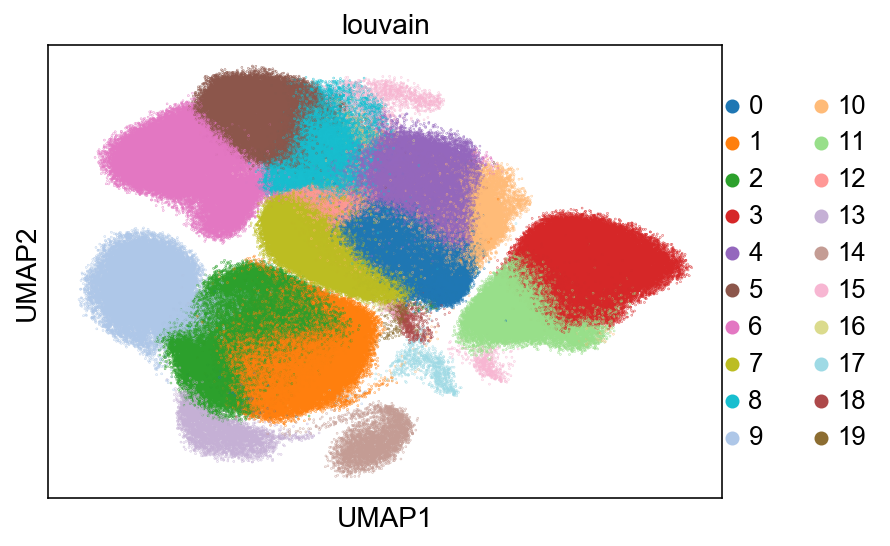

In [12]:
##sc.pl.tsne(adata, color='louvain')
##sc.pl.tsne(adata, color='batch_cov')
sc.pl.umap(adata, color='louvain')

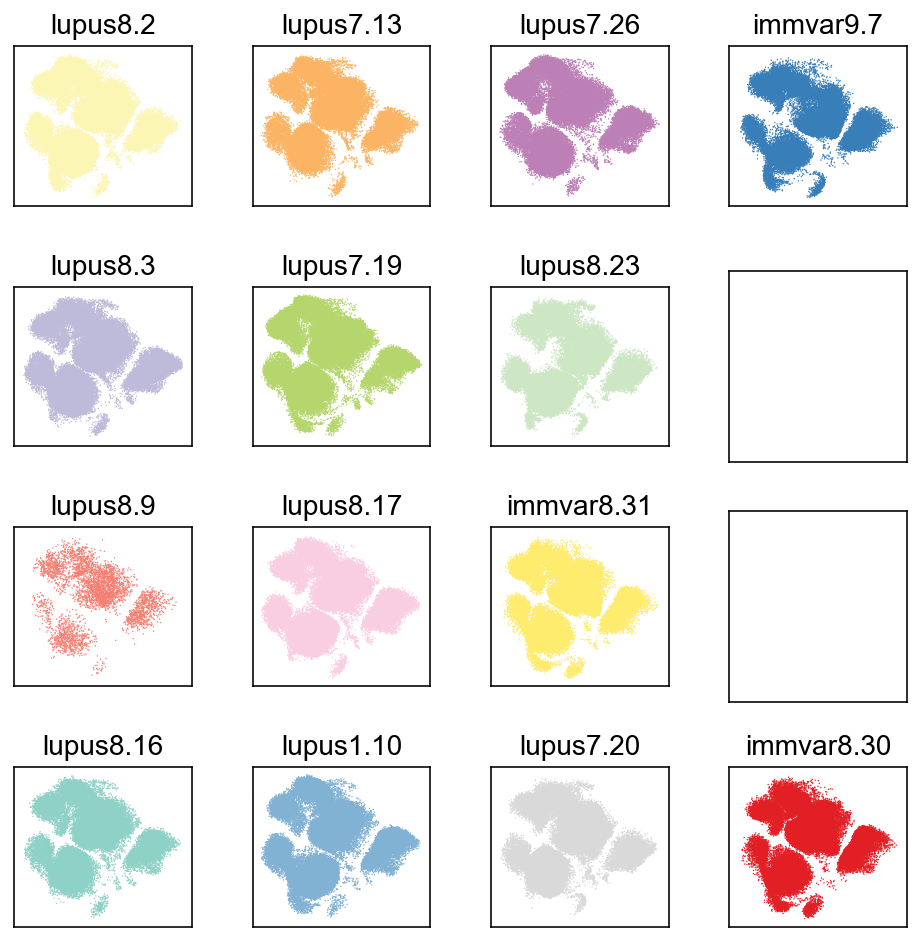

In [13]:
##sc.pl.umap(adata, color=['batch_cov'])
colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F"];

fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(7,7), sharex=True, sharey=True)
fig.tight_layout()
##plt.subplots_adjust(left=0, right=0.1, top=0.1, bottom=0, wspace=0.1, hspace=0.1)
##plt.subplots_adjust(wspace=0.1, hspace=0.1)

for batch_i in range(len(adata.obs.batch_cov.unique())) :
    batch = adata.obs.batch_cov.unique()[batch_i]
    col = colors[batch_i]
    sc.pl.umap(adata[adata.obs.batch_cov==batch,], color = "batch_cov", title=None, palette=[col,col], ax=ax[(batch_i-1)%4,math.floor(batch_i/4)], size=2, edgecolor="none", )
    ##ax[(ind_i-1)%4,math.floor(ind_i/4)].label_outer()
    ax[(batch_i-1)%4,math.floor(batch_i/4)].get_xaxis().set_visible(False)
    ax[(batch_i-1)%4,math.floor(batch_i/4)].get_yaxis().set_visible(False)
    ax[(batch_i-1)%4,math.floor(batch_i/4)].get_legend().remove()
    ax[(batch_i-1)%4,math.floor(batch_i/4)].set_title(batch)
    ax[(batch_i-1)%4,math.floor(batch_i/4)].set_aspect("equal")
    
fig.savefig('figures/umap.batch.png')

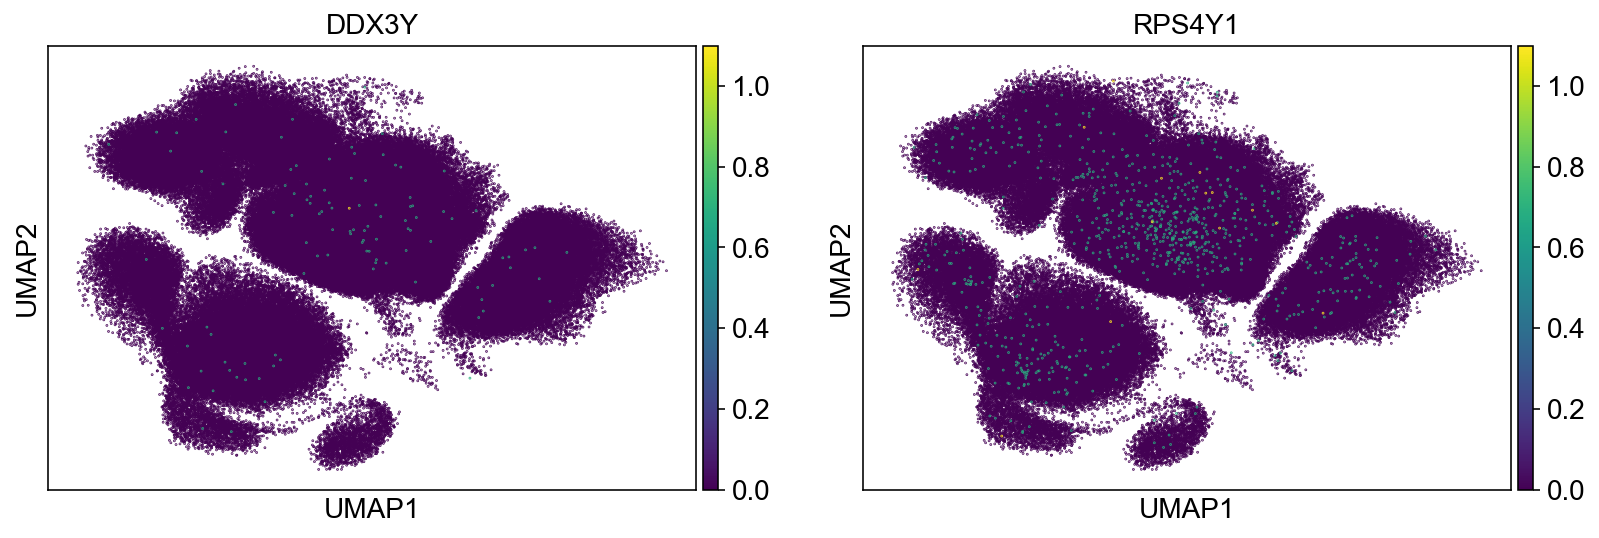

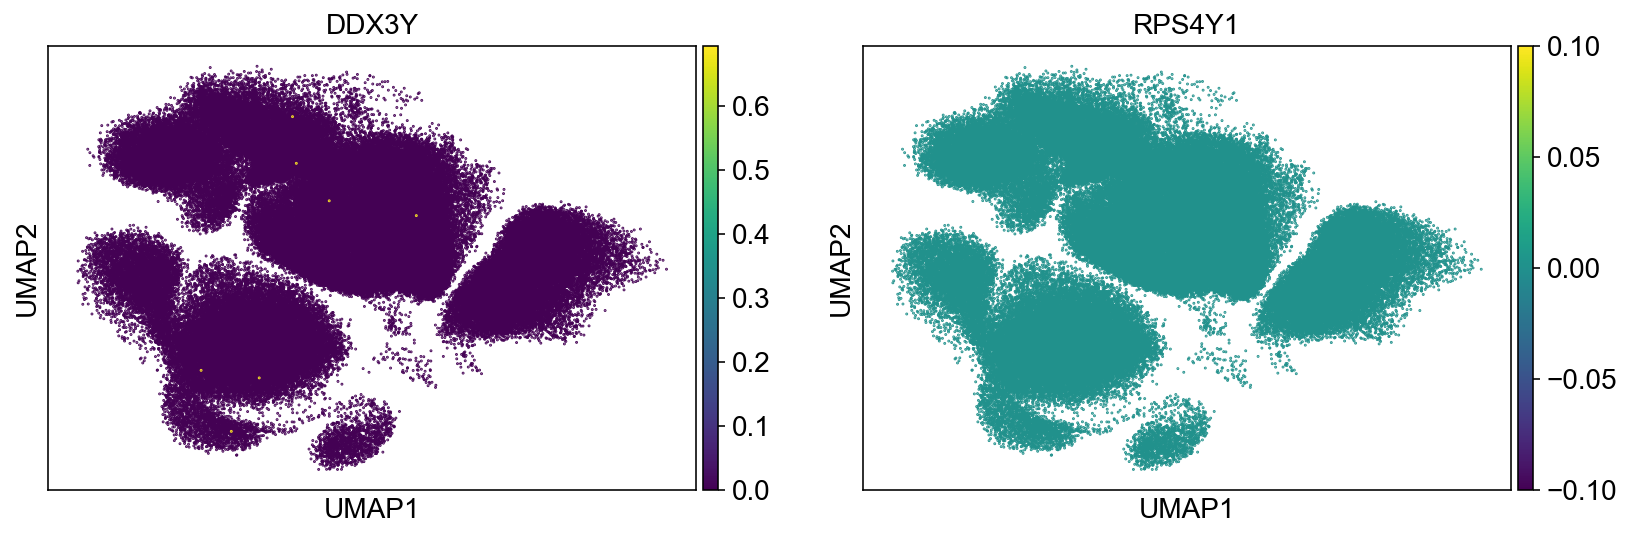

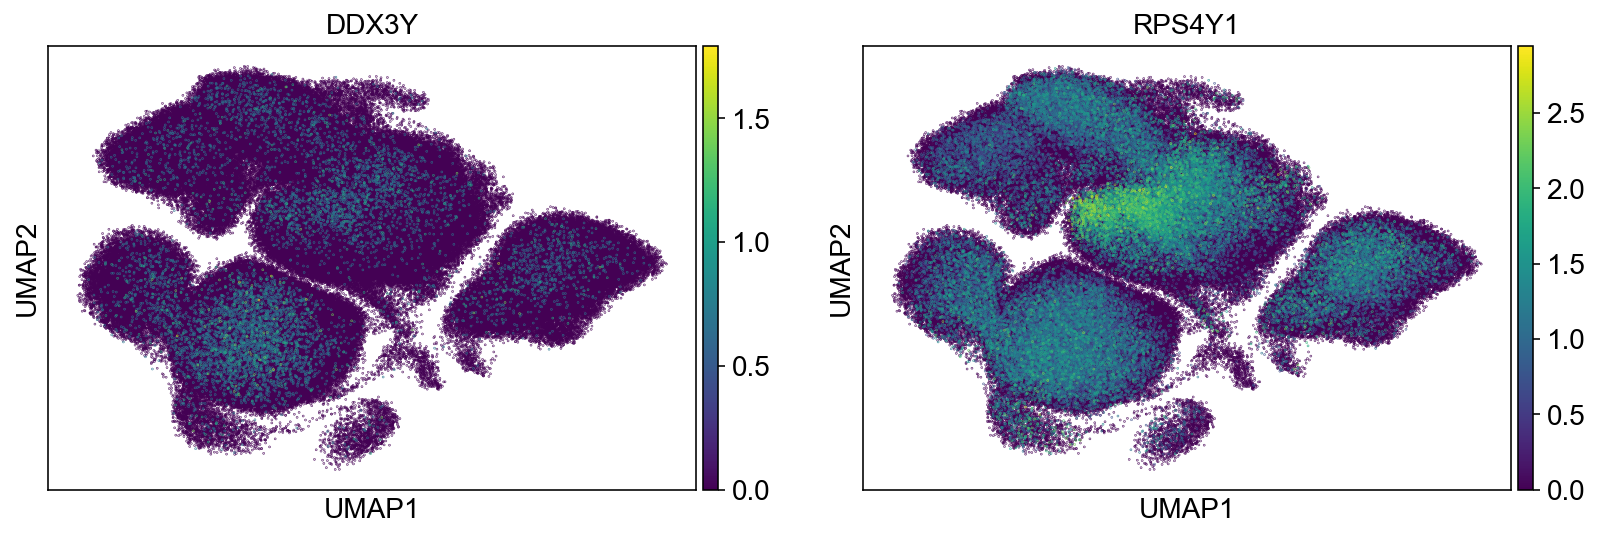

In [14]:
sc.pl.umap(adata[adata.obs.ind_cov.str.contains("IGTB")], color=["DDX3Y", "RPS4Y1"])
sc.pl.umap(adata[adata.obs.well.str.contains("immvar")], color=["DDX3Y", "RPS4Y1"])
sc.pl.umap(adata[adata.obs.disease_cov == "sle"], color=["DDX3Y", "RPS4Y1"])

# play with platelet adjustment

In [15]:
# adata.obsm.__delitem__("X_diffmap")
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata)
# sc.pl.umap(adata, color=['PF4','SDPR'])

In [16]:
# adata_small = adata[random.sample(range(1,744163),50000),]

# platgenes = ['ACTB','B2M','CCL5','CD99','CFL1','CLU','DYNLL1','F13A1','FLNA','FTH1','FTH1P5','GAPDH',
#              'GNAS','GNG11','GPX1','H3F3A','HBB','HBZ','HIST1H2AC','HIST1H2BM','HIST2H2AA3','HIST2H2BE','HLA-C',
#              'HLA-E','ITGA2B','ITM2B','MLH3','MYL12A','MYL6','NCOA4','NRGN','OAZ1','PF4','PGRMC1','PKM2',
#              'PPBP','PTMA','RGS10','RNF24','RPL41','SEPT5-GP1BB','SDPR','TAGLN2','TLN1','TMSB4X','TOP3B',
#              'TUBA4A','UBC','YWHAH']

# ##platgenes = ['PF4','PPBP','SDPR','GNG11']
# ##platgenes = ['PF4','PPBP']

# match = adata_small.raw.var_names.isin(platgenes)

# # For each cell compute fraction of counts in platelet genes vs. all genes
# adata_small.obs['percent_plat'] = np.sum(adata_small.raw[:, match].X, axis=1).A1 / np.sum(adata_small.raw.X, axis=1).A1
# adata_small.obs['PF4'] = adata_small.raw[:,"PF4"].X
# adata_small.obs['SDPR'] = adata_small.raw[:,"SDPR"].X
# adata_small.obs['GNG11'] = adata_small.raw[:,"GNG11"].X
# adata_small.obs['PPBP'] = adata_small.raw[:,"PPBP"].X

# adata_small.obsm.__delitem__("X_diffmap")
# adata_small_orig = sc.pp.neighbors(adata_small, n_neighbors=10, n_pcs=40, copy=True)
# sc.tl.umap(adata_small_orig)
# ##sc.pl.umap(adata_small, color=['PF4'])
# sc.pl.umap(adata_small_orig, color=['percent_plat','PF4','SDPR'])

# adata_small_new = sc.pp.regress_out(adata_small, ['PF4','SDPR','GNG11','PPBP'],copy=True)
# sc.pp.scale(adata_small_new, max_value=10)
# ##adata_small.obsm.__delitem__("X_diffmap")
# sc.tl.pca(adata_small_new, svd_solver='arpack')
# sc.pp.neighbors(adata_small_new, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_small_new)
# sc.pl.umap(adata_small_new, color=['percent_plat','PF4','SDPR'])

# adata_small_new2 = sc.pp.regress_out(adata_small, ['percent_plat'],copy=True)
# sc.pp.scale(adata_small_new2, max_value=10)
# ##adata_small.obsm.__delitem__("X_diffmap")
# sc.tl.pca(adata_small_new2, svd_solver='arpack')
# sc.pp.neighbors(adata_small_new2, n_neighbors=10, n_pcs=40)
# sc.tl.umap(adata_small_new2)
# sc.pl.umap(adata_small_new2, color=['percent_plat','PF4','SDPR'])

In [17]:
# sc.tl.pca(adata_small, svd_solver='arpack')
# sc.pp.neighbors(adata_small, n_neighbors=15, n_pcs=40)
# sc.tl.umap(adata_small)
# sc.pl.umap(adata_small, color=['percent_plat','PF4','SDPR'])

# Figure 1B: Projection and dropprint

## First, let's make the overall plot

saving figure to file ./figures/umap.disease.png


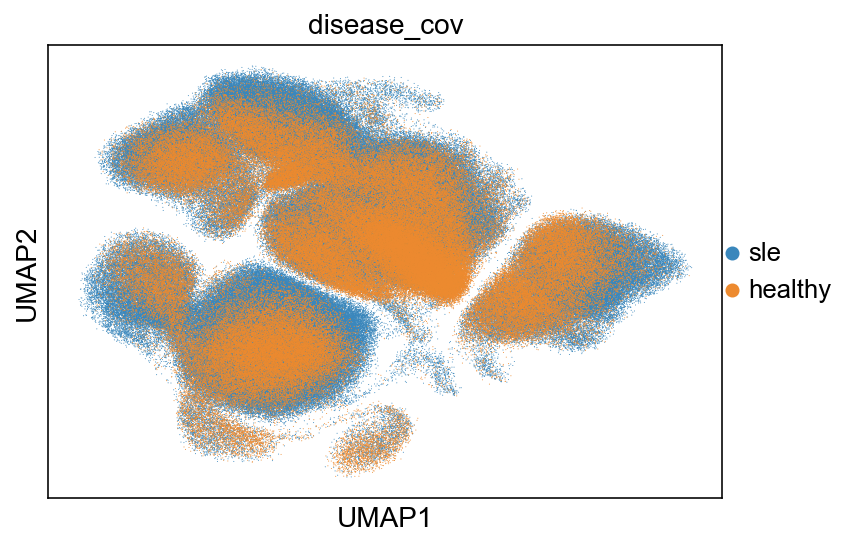

In [18]:
## Make disease plot (Fig. 1B)
## flipping the disease labels so that the healthy plots on top of the sle
adata.obs['disease_cov'] = pd.Categorical(adata.obs['disease_cov'],categories=['sle','healthy'], ordered=True)
adata.uns['disease_cov_colors'] = ['#3A87BC','#ED8A2F'];

##disease_tsne = sc.pl.tsne(adata, color='disease_cov', size=0.5)
##celltype_umap = sc.pl.umap(adata, color='ct_cov', size=1, edgecolor="none", save='.png')
disease_umap = sc.pl.umap(adata, color='disease_cov', size=1, edgecolor="none", save='.disease.png')
disease_umap = sc.pl.umap(adata, color='disease_cov', size=1, edgecolor="none")

## testing returning an axes object which should allow for more customization
## disease_tsne2 = sc.pl.tsne(adata, color='disease_cov', size=0.5, show=False)

## flipping the disease/healthy labels back for all of the downstream analysis
adata.obs['disease_cov'] = pd.Categorical(adata.obs['disease_cov'],categories=['healthy','sle'], ordered=True)

## Now, let's make a plot for each of the 16 people in batch 1 as a demo of variability

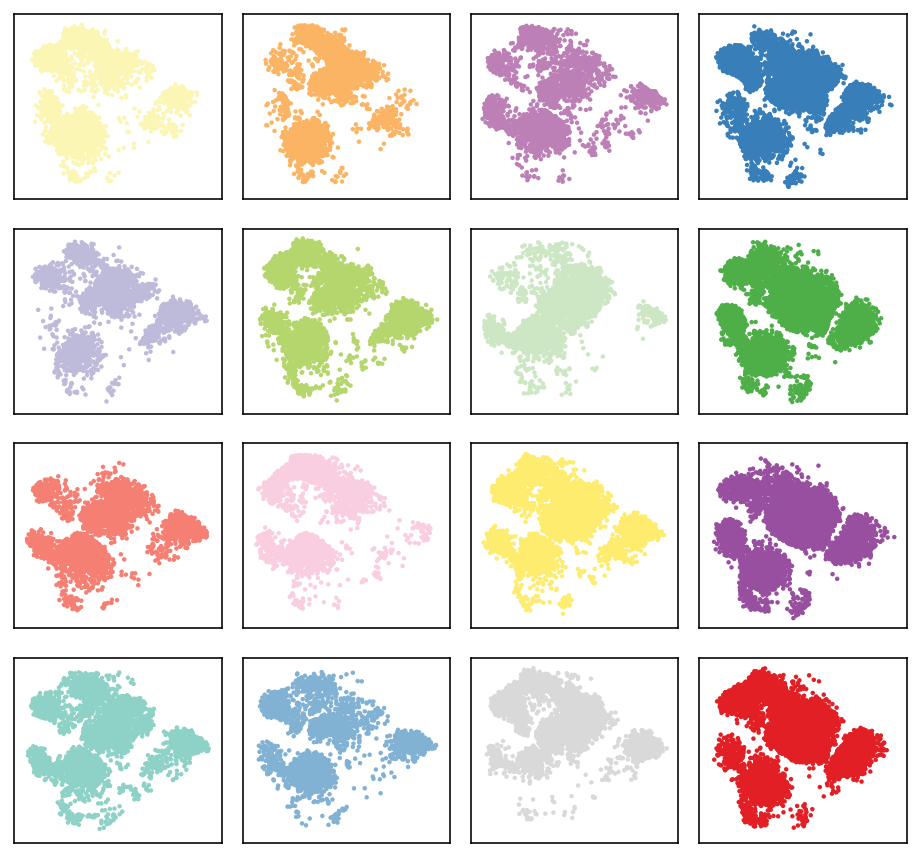

In [19]:
## let's plot 16 plots for the individuals in the first batch (Fig. 1B)
colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F"];
batch_07_19_inds = adata.obs.ind_cov[adata.obs.batch_cov=='lupus7.19'].unique()
batch_07_19_inds = np.sort(batch_07_19_inds.categories.values);

fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(7,7),sharex=True, sharey=True)
fig.tight_layout()
##plt.subplots_adjust(left=0, right=0.1, top=0.1, bottom=0, wspace=0.1, hspace=0.1)
plt.subplots_adjust(wspace=0.1, hspace=-0.2)

for ind_i in list(range(batch_07_19_inds.shape[0])) :
    ind = batch_07_19_inds[ind_i]
    col = colors[ind_i]
    sc.pl.umap(adata[adata.obs.ind_cov==ind,], color = "ind_cov", title=None, palette=[col,col], ax=ax[(ind_i-1)%4,math.floor(ind_i/4)], size=20, edgecolor="none")
    ##ax[(ind_i-1)%4,math.floor(ind_i/4)].label_outer()
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_xaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_yaxis().set_visible(False)
    ax[(ind_i-1)%4,math.floor(ind_i/4)].get_legend().remove()
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_title("")
    ax[(ind_i-1)%4,math.floor(ind_i/4)].set_aspect("equal")
    
fig.savefig('figures/umap.ind.png')

In [22]:
# ## let's plot 16 plots for the individuals in the first batch (Fig. 1B)
# colors = ["#8ED1C6","#FCF6B5", "#BEBAD9", "#F47F72", "#81B1D3", "#FBB463", "#B4D66C", "#F9CEE1", "#DAD9D9", "#BC80B7", "#CDE6C4", "#FEEC6E", "#E31F26", "#387EB9", "#4EAF49", "#984F9F"];

# for batch_i in list(range(adata.obs.ind_cov))
# batch_07_19_inds = adata.obs.ind_cov[adata.obs.batch_cov=='lupus7.19'].unique()
# batch_07_19_inds = np.sort(batch_07_19_inds.categories.values);

# fig,ax = plt.subplots(nrows=4,ncols=4, figsize=(7,7),sharex=True, sharey=True)
# fig.tight_layout()
# ##plt.subplots_adjust(left=0, right=0.1, top=0.1, bottom=0, wspace=0.1, hspace=0.1)
# plt.subplots_adjust(wspace=0.1, hspace=-0.2)

# for ind_i in list(range(batch_07_19_inds.shape[0])) :
#     ind = batch_07_19_inds[ind_i]
#     col = colors[ind_i]
#     sc.pl.umap(adata[adata.obs.ind_cov==ind,], color = "ind_cov", title=None, palette=[col,col], ax=ax[(ind_i-1)%4,math.floor(ind_i/4)], size=20, edgecolor="none")
#     ##ax[(ind_i-1)%4,math.floor(ind_i/4)].label_outer()
#     ax[(ind_i-1)%4,math.floor(ind_i/4)].get_xaxis().set_visible(False)
#     ax[(ind_i-1)%4,math.floor(ind_i/4)].get_yaxis().set_visible(False)
#     ax[(ind_i-1)%4,math.floor(ind_i/4)].get_legend().remove()
#     ax[(ind_i-1)%4,math.floor(ind_i/4)].set_title("")
#     ax[(ind_i-1)%4,math.floor(ind_i/4)].set_aspect("equal")
    
# fig.savefig('figures/umap.ind.png')

# Figure 1C: Cell type annotation of projection

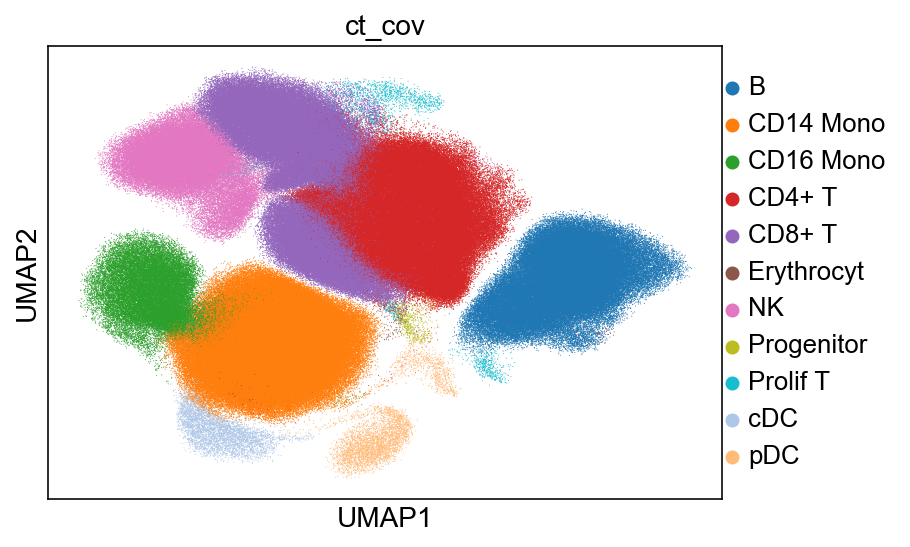

In [23]:
## Make cell type plot (Fig. 1C)
adata.uns['ct_cov_colors'] = sc.pl.palettes.vega_20_scanpy;
##celltype_tsne = sc.pl.tsne(adata, color='ct_cov', size=0.5)
celltype_umap = sc.pl.umap(adata, color='ct_cov',size=1, edgecolor="none")

In [24]:
## adata.obs.ct_cov = adata.obs.ct_cov.cat.add_categories(['MK'])
## adata.obs.ct_cov = adata.obs.ct_cov.cat.add_categories(['RBC'])

## do some manual cell type assignment
adata.obs.ct_cov[adata.obs.louvain == "0"] = "CD14 Mono"
adata.obs.ct_cov[adata.obs.louvain == "1"] = "B"
adata.obs.ct_cov[adata.obs.louvain == "2"] = "CD14 Mono"
adata.obs.ct_cov[adata.obs.louvain == "3"] = "CD4+ T"
adata.obs.ct_cov[adata.obs.louvain == "4"] = "CD4+ T"
adata.obs.ct_cov[adata.obs.louvain == "5"] = "CD8+ T"
adata.obs.ct_cov[adata.obs.louvain == "6"] = "CD8+ T"
adata.obs.ct_cov[adata.obs.louvain == "7"] = "NK"
adata.obs.ct_cov[adata.obs.louvain == "8"] = "CD8+ T"
adata.obs.ct_cov[adata.obs.louvain == "9"] = "CD4+ T"
adata.obs.ct_cov[adata.obs.louvain == "10"] = "CD16 Mono"
adata.obs.ct_cov[adata.obs.louvain == "11"] = "CD4+ T"
adata.obs.ct_cov[adata.obs.louvain == "12"] = "CD14 Mono"
adata.obs.ct_cov[adata.obs.louvain == "13"] = "B"
adata.obs.ct_cov[adata.obs.louvain == "14"] = "NK"
adata.obs.ct_cov[adata.obs.louvain == "15"] = "RBC"
adata.obs.ct_cov[adata.obs.louvain == "16"] = "MK"
adata.obs.ct_cov[adata.obs.louvain == "17"] = "cDC"
adata.obs.ct_cov[adata.obs.louvain == "18"] = "pDC"
adata.obs.ct_cov[adata.obs.louvain == "19"] = "Prolif T"
adata.obs.ct_cov[adata.obs.louvain == "20"] = "CD4+ T"
adata.obs.ct_cov[adata.obs.louvain == "21"] = "Progenitor"
adata.obs.ct_cov[adata.obs.louvain == "22"] = "B"

ValueError: Cannot setitem on a Categorical with a new category, set the categories first

In [ ]:
## Make cell type plot (Fig. 1C)
adata.uns['ct_cov_colors'] = sc.pl.palettes.vega_20_scanpy;
##celltype_tsne = sc.pl.tsne(adata, color='ct_cov', size=0.5)
celltype_umap = sc.pl.umap(adata, color='ct_cov', size=1, edgecolor="none", save='.celltype.png')
celltype_umap = sc.pl.umap(adata, color='ct_cov',size=1, edgecolor="none")

In [ ]:
## contam
sc.pl.umap(adata, color=["PTPRC","SELL","PF4", "SDPR", "GNG11", "PPBP"])

In [ ]:
## nk
sc.pl.umap(adata, color=["NCAM1"])

In [ ]:
## treg
sc.pl.umap(adata, color=["FOXP3","TNFRSF4","ENTPD1","CCR10"])

In [ ]:
## cycling
sc.pl.umap(adata, color=["KIAA0101","STMN1","TK1","MKI67"])

In [ ]:
sc.pl.umap(adata, color=["CD3D","CD8A","CD4","CD69"])

In [ ]:
## cd8 effector/naive
sc.pl.umap(adata, color=["CD8A","LYAR","CD27","DUSP2","CCL5","PASK","ZNF683"])

In [ ]:
## naive
sc.pl.umap(adata, color=["CCR7","LAT","IL7R"])

In [ ]:
sc.pl.umap(adata, color=["IL15RA", "ZNF683"])

In [ ]:
sc.pl.umap(adata[adata.obs.ind_cov.str.contains("IGTB")], color=["S1PR1"], size=5)
sc.pl.umap(adata[adata.obs.well.str.contains("immvar")], color=["S1PR1"], size=5)
sc.pl.umap(adata[adata.obs.disease_cov == "sle"], color=["S1PR1"], size=5)

In [ ]:
## y chromosome
sc.pl.umap(adata, color=["DDX3Y", "RPS4Y1", "FHIT","TRAT1"])

In [ ]:
## b cells, plasmablasts and pdcs
sc.pl.umap(adata, color=["MZB1", "IGJ", "CD79A"])

In [ ]:
## RBCs
sc.pl.umap(adata, color=["HBB"])

In [ ]:
sc.pl.umap(adata, color=["C1QA"])

In [ ]:
# sc.pl.tsne(adata, color='louvain')
# sc.pl.tsne(adata, color='batch_cov')

# Figure 1D: Cell type proportion differences between case/control

## First got to compute the percentages

In [ ]:
## we should be able to combine the cell type proportion estimates for the samples processed in Boston vs those processed in SF

In [ ]:
## Make proportion plots (Fig. 1D)

##adata_obs_small = adata.obs[(adata.obs.study_cov=="ImmVar") & (adata.obs.ind_cov.str.contains("IGTB")) | (~adata.obs.ind_cov.str.contains("IGTB") & (adata.obs.study_cov=="CLUES"))]
adata_obs_small = adata.obs[(adata.obs.well.str.contains("immvar")) & (adata.obs.ind_cov.str.contains("IGTB")) | (~adata.obs.ind_cov.str.contains("IGTB") & ~adata.obs.well.str.contains("immvar"))]

##ind_count = adata_obs_small.groupby(['ind_cov','study_cov','ct_cov','disease_cov','pop_cov','batch_cov'])['ct_cov'].count()
ind_count = adata_obs_small.groupby(['ind_cov','ct_cov','disease_cov','pop_cov','batch_cov'])['ct_cov'].count()

##ind_count = adata.obs.groupby(['ind_cov','study_cov','ct_cov','disease_cov','pop_cov'])['ct_cov'].count()
##ind_count = adata.obs.groupby(['ind_cov','ct_cov','disease_cov','pop_cov'])['ct_cov'].count()

##ind_count = ind_count.reset_index(name="counts")
ind_count_sums = ind_count.groupby(level=[0]).sum()
ind_count_sums = ind_count_sums.reset_index(name="counts")

ind_perc = ind_count/ind_count.groupby(level=[0]).transform(sum)*100
ind_perc = ind_perc.reset_index(name="ct_perc")

## filter samples that have < 100 cells
ind_perc = ind_perc[ind_perc.ind_cov.isin(ind_count_sums.ind_cov[ind_count_sums.counts > 100])]


In [ ]:
##ct_group = pd.DataFrame( {'ct_cov':['B','CD14 Monoc','CD16 Monoc', 'CD4+ T', 'CD8+ T', 'MK', 'NK', 'cDC', 'pDC','Progenitor','Proliferat'], 'ct_group':['lymph', 'mono', 'mono', 'lymph','lymph', 'mkc','lymph','dc','pdc','progen','lymph']})
ct_group = pd.DataFrame( {'ct_cov':['B','CD14 Mono','CD16 Mono', 'CD4+ T', 'CD8+ T', 'RBC', 'MK', 'NK', 'cDC', 'pDC','Progenitor','Proliferat'], 'ct_group':['lymph', 'mono', 'mono', 'lymph','lymph', 'rbc', 'mkc', 'lymph','dc','pdc','progen','lymph']})
ind_perc.ind_cov = ind_perc.ind_cov.apply(lambda x: x.split('_')[0])
ind_count_sums.ind_cov = ind_count_sums.ind_cov.apply(lambda x: x.split('_')[0])
ind_perc = ind_perc.set_index('ct_cov').join(ct_group.set_index('ct_cov'))
ind_perc.ind_cov = ind_perc.ind_cov.astype("str")
ind_perc.batch_cov = ind_perc.batch_cov.astype("str")
ind_perc.reset_index(inplace=True)
ind_perc.ct_cov = ind_perc.ct_cov.astype('category')

print('as a proportion of total PBMC ')

for ct_i in list(range(12)) :
    ct = ind_perc.ct_cov.cat.categories[ct_i]
    ct_perc = ind_perc.ct_perc[ind_perc.ct_cov==ct]
    disease = ind_perc.disease_cov[ind_perc.ct_cov==ct]
    disease = disease.astype("str")
    disease.values[disease=="sle"] = 0
    disease.values[disease=="healthy"] = 1
    disease = sm.add_constant(disease)
    ##data = data.assign(ct_perc=ct_perc)
    print('Cell type:'+ ct)
    est=sm.OLS(ct_perc.astype(float), disease.astype(float))
    est=est.fit()
    effect=est.params[1]
    pval=est.pvalues[1]
    #print(effect)
    #print(pval)
    print('Beta='+str(effect)+', pvalue='+str(pval))

## Next, let's plot the proportions

In [ ]:
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)
perc_plot.savefig("figures/violin.ct_cov.png")
#fig,ax = plt.subplots(nrows=1,ncols=10, figsize=(20,5))
#fig.tight_layout()

##for ct_i in list(range(10)) :
##    ct = ind_perc.ct_cov.cat.categories[ct_i]
##    sns.boxplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
##    sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=3, ax=ax[ct_i])

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=12, figsize=(20,5))
fig.tight_layout()


for ct_i in list(range(12)) :
    ct = ind_perc.ct_cov.cat.categories[ct_i]
    ax[ct_i].set_yscale('log')
    ax[ct_i].set_ylim(0.1,100)
    sns.boxplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[ind_perc.ct_cov == ct], color="0", size=3, ax=ax[ct_i])

In [ ]:
# fig,ax = plt.subplots(nrows=2,ncols=10, figsize=(20,10))
# fig.tight_layout()

# for ct_i in list(range(10)) :
#         ct = ind_perc.ct_cov.cat.categories[ct_i]
#         for pop_i in list(range(2)) :
#                 pop = ind_perc.pop_cov.cat.categories[pop_i]
                
#                 ##fig,ax = plt.subplots()
#                 ##fig.set_size_inches(2,8)
#                 sns.boxplot(x="disease_cov", y="ct_perc", data=ind_perc[(ind_perc.pop_cov == pop) & (ind_perc.ct_cov == ct)], color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[pop_i,ct_i])
#                 ##sns.swarmplot(x="disease_cov", y="ct_perc", data=ind_perc[(ind_perc.pop_cov == pop) & (ind_perc.ct_cov == ct)], color="0", size=3, ax=ax[pop_i,ct_i])


# for pop_i in list(range(2)) :
#     pop = ind_perc.pop_cov.cat.categories[pop_i]
#     perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc[(ind_perc.pop_cov == pop)], kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)
    
perc_plot = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', row="pop_cov", data=ind_perc, kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)


In [ ]:
##ax = sns.catplot(x='disease_cov', y='ct_perc', hue='ct_cov', data=ind_perc, kind='box', col='ct_cov', height=8, aspect=1/4)
##ax.savefig("figures/boxplot.cat.png")

# Figure 1E: Correlation with EHR

## Some initial data wrangling

ok, there should be 127 lupus patients and 42 immvar donors, we only have estimated PBMC numbers for 11 of them so the final joined table will only have 

In [ ]:
## Let's grab the clinical and labs data and compare to our single cell estimates
clues_clinical = pd.read_table("v2.clinical.data.txt", index_col=False)
clues_clinical.genotypeid = clues_clinical.genotypeid.apply(lambda x: x.split('_')[0])
clues_clinical.subjectid = clues_clinical.subjectid.astype("str")
joined = ind_perc.join(ind_count_sums.set_index('ind_cov'), on='ind_cov');
joined = joined.join(clues_clinical.set_index('genotypeid'), on='ind_cov')
##joined = ind_perc.join(clues_clinical.set_index('genotypeid'), on='ind_cov')

t1_labs = pd.read_table("T1labs.csv",sep=",")
t1_labs.SubjectID = t1_labs.SubjectID.astype("str")
joined = joined.join(t1_labs.set_index('SubjectID'), on='subjectid')

### test new code
joined.AbsBaso = joined.AbsBaso/1000
joined.AbsEosino = joined.AbsEosino/1000
joined.AbsLympho = joined.AbsLympho/1000
joined.AbsNeutro = joined.AbsNeutro/1000
joined.AbsMono = joined.AbsMono/1000

joined = joined.assign(pbmc = joined.WhiteBloodCell-joined.AbsNeutro-joined.AbsEosino-joined.AbsBaso)

joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(str)

## now let's add in white blood cell counts for the immvar patients
immvar_pbmc = pd.read_table("immvar.pbmc.csv", index_col=False, sep=",")
immvar_pbmc.pbmc = immvar_pbmc.pbmc - (np.mean(immvar_pbmc.pbmc) - np.mean(joined.pbmc))
## this is not the most efficient code but will suffice for now
for i in list(range(12)) :
    igtb = immvar_pbmc.immvarid[i]
    joined.pbmc[joined.ind_cov==igtb] = immvar_pbmc.pbmc[i]

joined = joined.assign(estimate=joined.ct_perc/100*joined.pbmc)

joined[["ind_cov","disease_cov","ct_cov"]] = joined[["ind_cov","disease_cov","ct_cov"]].astype(str)
joined.plaquenilnow = joined.plaquenilnow.fillna(0)
joined.cellceptnow = joined.cellceptnow.fillna(0)
joined.steroralnow = joined.steroralnow.fillna(0)
joined.acrlymphopenia = joined.acrlymphopenia.fillna(0)


In [ ]:
sns.distplot(joined.pbmc[~np.isnan(joined.pbmc)]);

ok, so current code joins to get estimates so for those samples with pbmc NAs, they will be filtered out

In [ ]:
##joined_pivot = joined.pivot_table(index=['ind_cov',"disease_cov","pbmc","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="ct_cov", values="estimate")
joined_pivot = joined.pivot_table(index=['ind_cov',"disease_cov","pbmc","counts","batch_cov","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns=["ct_cov"], values="estimate")
joined_pivot.reset_index(inplace=True)
joined_pivot.to_csv(name+"_joined_pivot_estimates.txt")

## this does not require the pbmc counts
##joined_pivot_perc = joined.pivot_table(index=['ind_cov',"disease_cov","counts","plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="ct_cov", values="ct_perc")
joined_pivot_perc = joined.pivot_table(index=['ind_cov',"disease_cov","counts","batch_cov", "plaquenilnow","cellceptnow","steroralnow","acrlymphopenia"], columns="ct_cov", values="ct_perc")
joined_pivot_perc.reset_index(inplace=True)
joined_pivot_perc.to_csv(name+"_joined_pivot_ct_perc.txt")

joined_pivot = joined_pivot[joined_pivot.pbmc > 0]
joined_pivot = joined_pivot[joined_pivot.pbmc < 10]

joined_pivot.disease_cov = pd.Categorical(joined_pivot.disease_cov,categories=['healthy','sle'], ordered=True)


##joined_agg = joined.groupby(['ind_cov','subjectid','disease_cov','ct_group','WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc'])['ct_perc'].sum()
joined_agg = joined.groupby(['ind_cov','subjectid','disease_cov','ct_group','plaquenilnow','cellceptnow','steroralnow',"acrlymphopenia",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc'])['ct_perc'].sum()

joined_agg = joined_agg.reset_index(name='ct_perc')

joined_agg[['WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc']] = joined_agg[['WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount','pbmc']].astype(float)

joined_agg = joined_agg.assign(estimate=joined_agg.ct_perc/100*joined_agg.pbmc)
joined_agg[["subjectid","disease_cov",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg[["subjectid","disease_cov",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(str)
joined_agg_pivot = joined_agg.pivot_table(index=['ind_cov', "subjectid", "pbmc","disease_cov",'plaquenilnow','cellceptnow','steroralnow',"acrlymphopenia","WhiteBloodCell","AbsMono",'AbsBaso',"AbsLympho","AbsNeutro","AbsEosino","PlatCount"], columns="ct_group", values="estimate")
joined_agg_pivot.reset_index(inplace=True);

joined_agg[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(float)
joined_agg_pivot[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg_pivot[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(float)


joined_agg_pivot_perc = joined_agg.pivot_table(index=['ind_cov', "subjectid", "pbmc","disease_cov",'plaquenilnow','cellceptnow','steroralnow',"acrlymphopenia","WhiteBloodCell","AbsMono",'AbsBaso',"AbsLympho","AbsNeutro","AbsEosino","PlatCount"], columns="ct_group", values="ct_perc")
joined_agg_pivot_perc.reset_index(inplace=True);

##joined_agg[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(float)
joined_agg_pivot_perc[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']] = joined_agg_pivot[["subjectid",'WhiteBloodCell','AbsMono','AbsLympho','AbsNeutro','AbsEosino','AbsBaso','PlatCount']].astype(float)

## filter for some really bad samples
joined_agg_pivot_clues = joined_agg_pivot[joined_agg_pivot.AbsMono > 5/1000]
joined_agg_pivot_clues = joined_agg_pivot_clues[joined_agg_pivot.AbsLympho > 5/1000]
joined_agg_pivot_clues = joined_agg_pivot_clues[joined_agg_pivot.WhiteBloodCell > 0]

joined_agg_clues = joined_agg[joined_agg.AbsMono > 5/1000]
joined_agg_clues = joined_agg_clues[joined_agg.AbsLympho > 5/1000]
joined_agg_clues = joined_agg_clues[joined_agg.WhiteBloodCell > 0]

## Plot correlation for monocytes and lymphocytes

In [ ]:
## calculate correlation
lympho_cor = stats.pearsonr(joined_agg_pivot_clues.lymph, joined_agg_pivot_clues.AbsLympho)
mono_cor = stats.pearsonr(joined_agg_pivot_clues.mono, joined_agg_pivot_clues.AbsMono)

fig,ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
fig.tight_layout()

sns.scatterplot(x='lymph', y='AbsLympho', data=joined_agg_pivot_clues, color='#d62728',ax=ax[0])
ax[0].set(xlabel="Single Cell Counts x 10e9/L", ylabel="CBC Cell Counts x 10e9/L")
ax[0].plot(ax[0].get_xlim(), ax[0].get_xlim(), '--', color='#000000')

sns.scatterplot(x='mono', y='AbsMono', data=joined_agg_pivot_clues, color='#ff7f0e',ax=ax[1])
ax[1].set(xlabel="Single Cell Counts x 10e9/L", ylabel="CBC Cell Counts x 10e9/L")
ax[1].plot(ax[1].get_xlim(), ax[1].get_xlim(), '--', color='#000000')


print(lympho_cor)
print(mono_cor)

## Plot cell abundance

In [ ]:
## now let's also plot the monocyte and lymphocyte counts between sle and control
## immvar samples are
##IGTB1290 IGTB1372 IGTB141 IGTB143 IGTB1506 IGTB1539 IGTB1540 IGTB1542 IGTB1575 IGTB1650 IGTB1921 IGTB195 IGTB256 IGTB469 IGTB498 IGTB508 IGTB514 IGTB645 IGTB670 IGTB826 IGTB884 IGTB986

joined_agg.disease_cov = pd.Categorical(joined_agg.disease_cov,categories=['healthy','sle'], ordered=True)
joined_agg_pivot.disease_cov = pd.Categorical(joined_agg_pivot.disease_cov,categories=['healthy','sle'], ordered=True)


fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(10,8))
fig.tight_layout()

for cg_i in [0, 1,2] :
    cg = ['mono', 'lymph','lymph'][cg_i]
    sns.boxplot(x="disease_cov", y=cg, data=joined_agg_pivot[~(joined_agg_pivot.AbsMono < 5/1000)], color=['#ff7f0e','#d62728','#7f7f7f'][cg_i], ax=ax[cg_i])
    sns.swarmplot(x="disease_cov", y=cg, data=joined_agg_pivot[~(joined_agg_pivot.AbsMono < 5/1000)], color="0", size=3, ax=ax[cg_i])

    
## now let's also plot the monocyte and lymphocyte counts between sle and control
## immvar samples are
##IGTB1290 IGTB1372 IGTB141 IGTB143 IGTB1506 IGTB1539 IGTB1540 IGTB1542 IGTB1575 IGTB1650 IGTB1921 IGTB195 IGTB256 IGTB469 IGTB498 IGTB508 IGTB514 IGTB645 IGTB670 IGTB826 IGTB884 IGTB986

# ##joined_agg.disease_cov = pd.Categorical(joined_agg.disease_cov,categories=['healthy','sle'], ordered=True)
# joined_agg_pivot_perc.disease_cov = pd.Categorical(joined_agg_pivot_perc.disease_cov,categories=['healthy','sle'], ordered=True)


# fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(10,8))
# fig.tight_layout()

# for cg_i in [0, 1,2] :
#     cg = ['mono', 'lymph','lymph'][cg_i]
#     sns.boxplot(x="disease_cov", y=cg, data=joined_agg_pivot_perc[~(joined_agg_pivot_perc.AbsMono < 5/1000)], color=['#ff7f0e','#d62728','#7f7f7f'][cg_i], ax=ax[cg_i])
#     sns.swarmplot(x="disease_cov", y=cg, data=joined_agg_pivot_perc[~(joined_agg_pivot_perc.AbsMono < 5/1000)], color="0", size=3, ax=ax[cg_i])


In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=12, figsize=(20,5))
fig.tight_layout()

for ct_i in list(range(12)) :
    ct = ind_perc.ct_cov.cat.categories[ct_i]
    sns.boxplot(x="disease_cov", y=ct, data=joined_pivot, color=sc.pl.palettes.vega_20_scanpy[ct_i], ax=ax[ct_i])
    sns.swarmplot(x="disease_cov", y=ct, data=joined_pivot, color="0", size=3, ax=ax[ct_i])
    
perc_plot = sns.catplot(x='disease_cov', y='estimate', hue='ct_cov', data=joined, kind='violin', col='ct_cov', dodge=False, aspect=0.4, sharex=False, sharey=False)


In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(2,4)
ax = sns.boxplot(x="disease_cov", y="pbmc", data=joined_pivot)
ax = sns.swarmplot(x="disease_cov", y="pbmc", data=joined_pivot, color="0", size=3)


# Figure 1F: Validation of lymphopenia in EHR

In [ ]:
## Now let's analyze the EHR data
ehr = pd.read_table("meena_lupus_2017-11-15.csv", sep=",")
ehr_pivot = ehr.pivot_table(index=['Patient_ID',"Lab_Age","Patient_Sex","Patient_Race","CASE"],columns="Lab_Name",values="Lab_Value")
ehr_pivot.reset_index(inplace=True)
ehr_pivot = ehr_pivot[ehr_pivot['monocyte abs count'] < 5]
ehr_pivot = ehr_pivot[ehr_pivot['lymphocyte abs cnt'] < 6]

fig,ax = plt.subplots(nrows=3,ncols=3, figsize=(10,24))
fig.tight_layout()

## find samples with both monocyte and lymphocyte count
for cg_i in [0, 1, 2] :
    cg = ['monocyte abs count', 'lymphocyte abs cnt', 'wbc count'][cg_i]
    for r_i in [0,1,2] :
        race = ['White or Caucasian', 'Black or African American', 'Asian'][r_i]
        sns.boxplot(x="CASE", y=cg, data=ehr_pivot[ehr_pivot.Patient_Race==race], color=['#ff7f0e','#d62728','#7f7f7f'][cg_i], ax=ax[r_i,cg_i])
        sns.swarmplot(x="CASE", y=cg, data=ehr_pivot[ehr_pivot.Patient_Race==race], color="0", size=3, ax=ax[r_i,cg_i])
           
perc_plot = sns.catplot(x='CASE', y='Lab_Value', col='Lab_Name', data=ehr, kind='violin', row='Patient_Race', dodge=False, aspect=0.4, sharex=False, sharey=False)

## test for differences in abundance
for cg_i in [0, 1] :
    cg = ['monocyte abs count', 'lymphocyte abs cnt'][cg_i]
    for race in ['White or Caucasian', 'Black or African American', 'Asian'] :
        abundance = ehr_pivot[ehr_pivot.Patient_Race==race][cg].values
        disease = ehr_pivot.CASE[ehr_pivot.Patient_Race==race]
        disease = sm.add_constant(disease)
        print('Cell type:'+ ct +",Race:"+race)
        est=sm.OLS(abundance.astype(float), disease.astype(float))
        est=est.fit()
        effect=est.params[1]
        pval=est.pvalues[1]
        print('Beta='+str(effect)+', pvalue='+str(pval))

In [ ]:
sns.scatterplot(joined_agg_pivot_clues.lymph, joined_agg_pivot_clues.acrlymphopenia)

# Supplementary figures

## Take a look at the effects of treatment

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(10,8))
fig.tight_layout()

joined_pivot_perc.plaquenilnow[(joined_pivot_perc.disease_cov=="healthy")] = "2";
joined_pivot_perc.cellceptnow[(joined_pivot_perc.disease_cov=="healthy")] = "2";
joined_pivot_perc.steroralnow[(joined_pivot_perc.disease_cov=="healthy")] = "2";

for drug_i in [0, 1,2] :
    drug = ["plaquenilnow", "cellceptnow", "steroralnow"][drug_i]
    ##cg = ['mono', 'lymph','lymph'][cg_i]
    sns.boxplot(x=drug, y="CD14 Mono", data=joined_pivot_perc, color='#ff7f0e', ax=ax[drug_i])

fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(10,8))
fig.tight_layout()

for drug_i in [0, 1,2] :
    drug = ["plaquenilnow", "cellceptnow", "steroralnow"][drug_i]
    ##cg = ['mono', 'lymph','lymph'][cg_i]
    sns.boxplot(x=drug, y="CD4+ T", data=joined_pivot_perc, color='#d62728', ax=ax[drug_i])
